In [1]:
import gdal
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
from glob import glob
import shapely
import random
from tqdm import tqdm
from collections import Counter
from pybob.GeoImg import GeoImg
import osr
from pybob.image_tools import create_mask_from_shapefile
import gc
import imageio
import time
import shutil
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_mask(maskshp,geotrf,shape,p='4326'):
    img=np.zeros((shape[0],shape[1]))
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    
    trf=(geotrf[0], geotrf[1], geotrf[2], geotrf[3], geotrf[4], geotrf[5])
    drv = gdal.GetDriverByName('MEM')
    dst = drv.Create('', shape[1], shape[0], 1, gdal.GDT_UInt16)

    sp = dst.SetProjection(proj)
    sg = dst.SetGeoTransform(trf)

    wa = dst.GetRasterBand(1).WriteArray(img)
    del wa, sg, sp
    img_bob = GeoImg(dst)
    mask = create_mask_from_shapefile(img_bob, maskshp)
    return mask
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def tif_save_bands(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[2],img.shape[1],img.shape[0],6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    for i in range(img.shape[0]):
        new_img.GetRasterBand(i+1).WriteArray(img[i,:,:])
    new_img.FlushCache()
    del new_img
def tif_save(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[1],img.shape[0],1,6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    new_img.GetRasterBand(1).SetNoDataValue(0)
    new_img.GetRasterBand(1).WriteArray(img)
    new_img.FlushCache()
    del new_img

# 分区mask

In [101]:
f=glob('/data4/Ukraine_img/M_and_L/*TCN.tif')[0]
ds=gdal.Open(f)
trf=ds.GetGeoTransform()
shp=ds.ReadAsArray().shape
mask=get_mask('/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_ROI.shp',trf,[shape[1],shape[2]],p='4326')

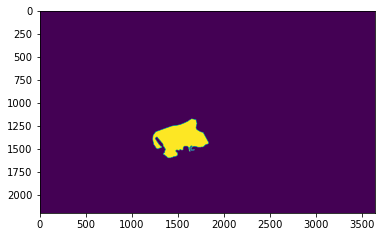

In [174]:
plt.imshow(mask)

In [112]:
l=gpd.read_file('/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_25April2022_CDA.shp')['Main_Damag']

In [161]:
labels_date={'A':['20210910'],'A-B':['20220227','20220309','20220314','20220428','20220503','20220508'],'B':[],'B-C':['20220523','20220528','20220602','20220607','20220612','20220617','20220622','20220627']}
points_path='/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_25April2022_CDA.shp'


In [162]:
points=gpd.read_file(points_path)
points=points.to_crs(4326)
points=points[points['Main_Damag']<4.5]
k={1:'Destroyed',2:'Severe Damage',3:'Moderate Damage',4:'Possible Damage'}
DmgCls=[k[i] for i in list(points['Main_Damag'])]
points=gpd.GeoDataFrame({'a':list(range(len(points))),
                        'SiteID':['Industrial Facility']*len(points),
                        'SensDt':['2022-04-25']*len(points),
                        'DmgCls':DmgCls,
                        'StlmtNme':['Azovstal']*len(points),
                        'geometry':list(points['geometry'])})
points.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_B_2022-04-25.shp')
points_path='/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_B_2022-04-25.shp'

['/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN.tif',
 '/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2.tif',
 '/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2.tif',
 '/data4/Ukraine_img/M_and

# 转换图像为Patch

In [177]:
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def get_patch(data,size):
    img=data['img']
    trf=data['trf']
    shape=img.shape
    img=np.pad(img,((0,0),(0,size-shape[1]%size),(0,size-shape[2]%size)),'constant',constant_values=0)
    shape=img.shape
    img=img.reshape([shape[0],int(shape[1]/size),-1,shape[2]])
    shape=img.shape
    img=img.reshape([shape[0],shape[1],shape[2],int(shape[3]/size),-1])
    return {'img':img.transpose((0,1,3,2,4)),'trf':(trf[0]-trf[1]/2,trf[1]*size,trf[2],trf[3]-trf[5]/2,trf[4],trf[5]*size)}
size=6
fs10=glob('/data4/Ukraine_img/M_and_L/*.tif')
fs10=[i for i in fs10 if i[-5:]!='r.tif']
fs10.sort()
fs10
img_pathes=fs10
# img_pathes=['/data2/Syria_img/Raqqa_enhance-A-B-4_20130213_treated.tif']
print(img_pathes)

for path in img_pathes:
    # try:    
    
    print(path)
    data=read_img(path)
    ddata=read_img(path.replace('.tif','_bandother.tif'))
    for i in range(4):
        data['img'][i,:,:][mask==0]=0
    print(data['img'].shape)
    data2=get_patch(data,6)
    ddata2=get_patch(ddata,3)
    print(data2['img'].shape)
    print(data2['trf'])
    d=data2['img'][:4].astype(np.int16)
    dd=ddata2['img'].astype(np.int16)
    info={'readme':'trf分别为patch左上角坐标(不是左上角像元的中心坐标)和patch的长度',
    'trf':data2['trf'],'shape':[data['img'].shape,d.shape],'img10':d,'img20':dd}

    # np.save(path.replace('.tif',f'_size_{size}.npy'),d)
    print('max:',d.max())
    torch.save(info,path.replace('.tif',f'_size_{size}_Azovstal_info.pth'))
    del data,data2,d
    gc.collect()
    # except:
    #         print('ERROR',path)

['/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN.tif', '/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2.tif', '/data4/Ukraine_img/M_and_L/20220602T0

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4484
/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 5716
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4100
/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2.tif
(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4400
/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2.tif
(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7984
/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4500
/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0
/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0
/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4740
/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2.tif
(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 4704
/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6668
/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2.tif
(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6180
/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2.tif
(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 6600
/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7172
/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7540
/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 8044
/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 7396
/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(10, 2196, 3638)
(10, 367, 607, 6, 6)
(37.461319399531256, 0.0005389891704717128, 0.0, 47.22214378218874, 0.0, -0.0005389891704717128)
max: 0


In [178]:
fs=glob('/data4/Ukraine_img/M_and_L/*_Azovstal_info.pth')
fs.sort()
fs

['/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_Azovstal_info.pth',
 '/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_Azovstal_info.pth',
 '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_Azovstal_info.pth',
 '/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_Azovstal_info.pth',
 '/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_Azovstal_info.pth',
 '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_Azovstal_info.pth',
 '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_Azovstal_info.pth',
 '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_Azovstal_info.pth',
 '/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_Azovstal_info.pth',
 '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_Azovstal_info.pth',
 '/data4/Ukraine_img/M_and_L/20220508T082

# 制作patch的label

In [151]:
def get_dam_mask(point,patch_file,weight):
    trf=torch.load(patch_file)['trf']
    shape=torch.load(patch_file)['shape'][1]
    p_coor=[shapely.geometry.mapping(list(point)[i])['coordinates'] for i in range(len(point))]
    mask=np.zeros((shape[1],shape[2]))
    p_x_y=[[int((i[0]-trf[0])/trf[1]),int((i[1]-trf[3])/trf[5])] for i in p_coor]
    for i in p_x_y:
        try:
            mask[i[1],i[0]]+=weight
        except:
            pass
    return mask
def get_mask(points_path,patch_path):
    n=points_path.split("_")[-2]
    df=gpd.read_file(points_path)
    print(len(df))
    point_num={}
    point=df[df['DmgCls']=='Destroyed']['geometry']
    point_num['destroyed']=len(point)
    print('destroyed:',len(point))
    mask_destroyed=get_dam_mask(point,patch_path,1)
    point=df[df['DmgCls']=='Severe Damage']['geometry']
    point_num['severe']=len(point)
    print('Severe Damage:',len(point))
    mask_severe=get_dam_mask(point,patch_path,1)
    point=df[df['DmgCls']=='Moderate Damage']['geometry']
    point_num['moderate']=len(point)
    print('Moderate Damage:',len(point))
    mask_moderate=get_dam_mask(point,patch_path,1)

    mask=mask_destroyed*6+mask_severe*3+mask_moderate
    date=df['SensDt'][0]
    print(f'{n}  {date}得分',dict(Counter(list(mask.flatten()))))
    mask_type=np.zeros(mask.shape)
    mask_type[mask>0]=1
    mask_type[mask>=6]=2
    print(f'{date}损毁类型',Counter(list(mask_type.flatten())))
    all_mask=[mask_destroyed,mask_severe,mask_moderate,mask,mask_type]
    info='5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
    result={'info':info,'point_num':point_num,'mask':all_mask}
    return result

In [163]:

patch_path='/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_area4_info.pth'
result=get_mask(points_path,patch_path)
save_path=points_path.replace('.shp','_size_6_dammask.pth.tar').replace('/home/hk/python_script/Ukraine/data/UNOSAT/U/','/data4/Ukraine_img/M_and_L/')
torch.save(result,save_path)
print('save:',save_path)
print('__________________________SAVE SUCCESS__________________________')

# for point_path in points_list:
#     patch_path='/data4/Ukraine_img/U_bandother/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_3_info.pth'
#     result=get_mask(point_path,patch_path)
#     torch.save(result,point_path.replace('.shp','_size_3_dammask.pth.tar'))
#     print('__________________________SAVE SUCCESS__________________________')


220
destroyed: 50
Severe Damage: 54
Moderate Damage: 101
B  2022-04-25得分 {0.0: 222584, 1.0: 90, 7.0: 6, 3.0: 45, 6.0: 34, 9.0: 2, 12.0: 3, 4.0: 3, 2.0: 1, 24.0: 1}
2022-04-25损毁类型 Counter({0.0: 222584, 1.0: 139, 2.0: 46})
save: /home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_B_2022-04-25_size_6_dammask.pth.tar
__________________________SAVE SUCCESS__________________________


# 制作样本

In [ ]:
resul

In [180]:
# masks={
#     'A':None,
#     'B':glob(f'/data2/Syria_img/{city}_B_*_treated_size_120_dammask.pth.tar')[0],
#     'C':glob(f'/data2/Syria_img/{city}_C_*_treated_size_120_dammask.pth.tar')[0],
#     'D':glob(f'/data2/Syria_img/{city}_D_*_treated_size_120_dammask.pth.tar')[0],
#     'Z':None
# }


def get_samples(pre_patch,post_patch,dammask_after,dammask_now,dammask_before):
        # if pre_patch[0].shape!=post_patch[0].shape:
        #         raise('SHAPE ERROR')
        if pre_patch[0].shape[0]!=4 or post_patch[0].shape[0]!=4:
                raise
        if pre_patch[1].shape[0]!=6 or post_patch[1].shape[0]!=6:
                raise
                               
        shape=pre_patch[0].shape
        print(shape)
        zz=np.zeros((shape[1],shape[2]))
        samples=[]
        if dammask_now is not None:
                for x in range(shape[1]):
                        for y in range(shape[2]):
                                
                                if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                        continue
                                else:
                                        samples.append([[x,y],[None,[int(i[x,y]) for i in dammask_now['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                        zz[x,y]=1
        else:
                if dammask_before is None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if dammask_after['mask'][0][x,y]==0:
                                                        samples.append([[x,y],[None,[int(i[x,y]) for i in dammask_after['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                if dammask_after is None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if dammask_before['mask'][0][x,y]>0:
                                                        samples.append([[x,y],[[int(i[x,y]) for i in dammask_before['mask']],None],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                if dammask_before is not None and dammask_after is not None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if (dammask_after['mask'][0][x,y]>0 and dammask_before['mask'][0][x,y]>0) or (dammask_after['mask'][0][x,y]==0 and dammask_before['mask'][0][x,y]==0):
                                                        samples.append([[x,y],[[int(i[x,y]) for i in dammask_before['mask']],[int(i[x,y]) for i in dammask_after['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                                        
        return samples,zz

In [194]:
dammasks_path={'Azovstal':{'A':None,'B':'/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_B_2022-04-25_size_6_dammask.pth.tar','Z':None}}
dammasks_path

{'Azovstal': {'A': None,
  'B': '/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_B_2022-04-25_size_6_dammask.pth.tar',
  'Z': None}}

In [195]:
img_pathes={}
img_pathes1={}
img_pathes1['A']=[fs[0]]
img_pathes1['A-B']=fs[1:8]
img_pathes1['B']=[]
img_pathes1['B-Z']=fs[8:]
img_pathes['Azovstal']=img_pathes1
img_pathes

{'Azovstal': {'A': ['/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_Azovstal_info.pth'],
  'A-B': ['/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_Azovstal_info.pth',
   '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_Azovstal_info.pth',
   '/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_Azovstal_info.pth',
   '/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_Azovstal_info.pth',
   '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_Azovstal_info.pth',
   '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_Azovstal_info.pth',
   '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_Azovstal_info.pth'],
  'B': [],
  'B-Z': ['/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_Azovstal_info.pth',
   '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size

-------------------------------------
['A', 'A-B', 'B', 'B-Z']


A-B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_B_2022-04-25_size_6_dammask.pth.tar
load img: A-B
['/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_Azovstal_info.pth']
/data4/Ukraine_img/M_and_L/20220227T082911_20220227T083303_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


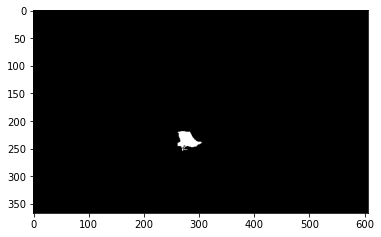

(4, 367, 607, 6, 6)
writing samples 723
/data4/Ukraine_img/M_and_L/20220309T082801_20220309T083304_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


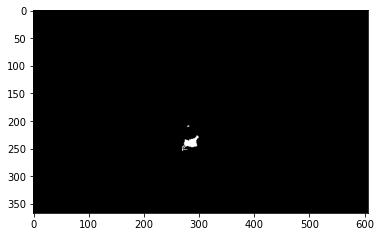

(4, 367, 607, 6, 6)
writing samples 288
/data4/Ukraine_img/M_and_L/20220314T082719_20220314T083610_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


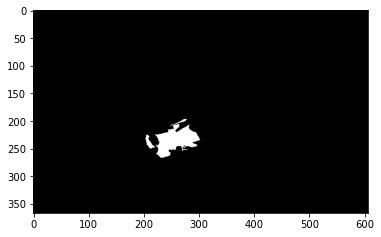

(4, 367, 607, 6, 6)
writing samples 2606
/data4/Ukraine_img/M_and_L/20220319T082651_20220319T083304_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


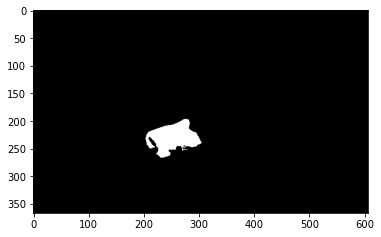

(4, 367, 607, 6, 6)
writing samples 3616
/data4/Ukraine_img/M_and_L/20220324T082609_20220324T083426_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


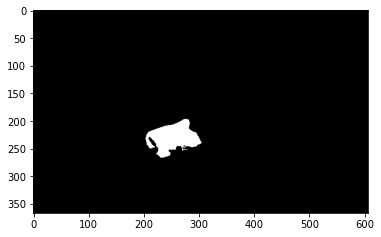

(4, 367, 607, 6, 6)
writing samples 3616
/data4/Ukraine_img/M_and_L/20220329T082601_20220329T083216_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


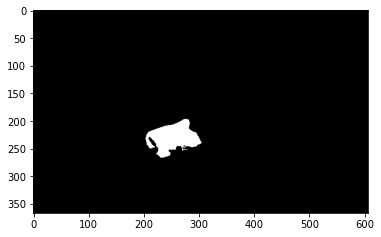

(4, 367, 607, 6, 6)
writing samples 3616
/data4/Ukraine_img/M_and_L/20220403T082559_20220403T083553_T37TCN2_size_6_Azovstal_info.pth


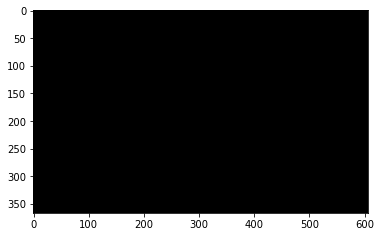

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]




B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_B_2022-04-25_size_6_dammask.pth.tar


B-Z
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_B_2022-04-25_size_6_dammask.pth.tar
load img: B-Z
['/data4/Ukraine_img/M_and_L/20220428T082611_20220428T083305_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2_size_6_Azovstal_info.pth', '/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2_size_6

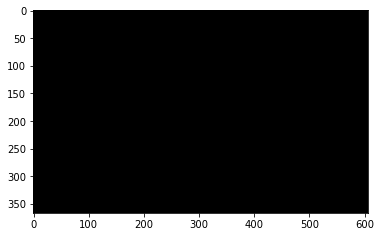

(4, 367, 607, 6, 6)
writing samples 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220503T082559_20220503T083512_T37TCN2_size_6_Azovstal_info.pth


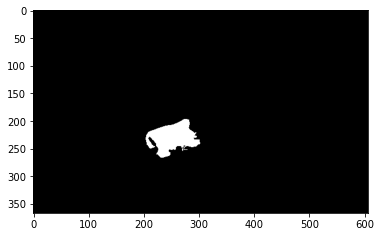

(4, 367, 607, 6, 6)
writing samples 41
/data4/Ukraine_img/M_and_L/20220508T082611_20220508T083304_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


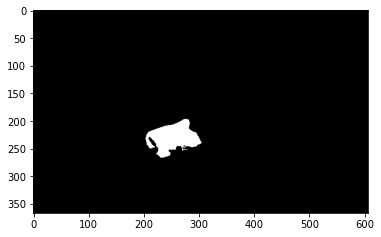

(4, 367, 607, 6, 6)
writing samples 44


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220523T082559_20220523T082946_T37TCN2_size_6_Azovstal_info.pth


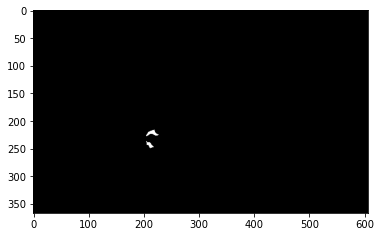

(4, 367, 607, 6, 6)
writing samples 13
/data4/Ukraine_img/M_and_L/20220528T082611_20220528T083641_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


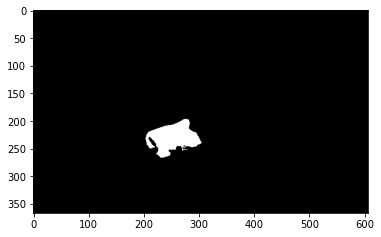

(4, 367, 607, 6, 6)
writing samples 44
/data4/Ukraine_img/M_and_L/20220602T082559_20220602T082807_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


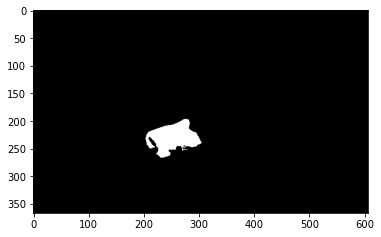

(4, 367, 607, 6, 6)
writing samples 44
/data4/Ukraine_img/M_and_L/20220607T082611_20220607T083435_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


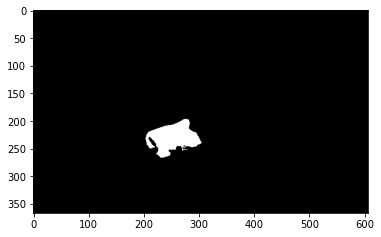

(4, 367, 607, 6, 6)
writing samples 44
/data4/Ukraine_img/M_and_L/20220612T082609_20220612T082840_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


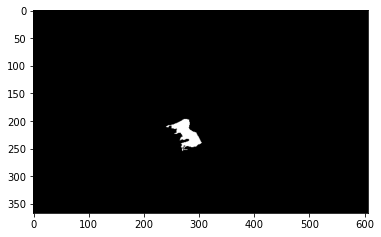

(4, 367, 607, 6, 6)
writing samples 13
/data4/Ukraine_img/M_and_L/20220617T082611_20220617T083253_T37TCN2_size_6_Azovstal_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


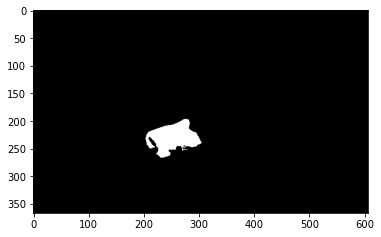

(4, 367, 607, 6, 6)
writing samples 44


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/M_and_L/20220622T082609_20220622T082834_T37TCN2_size_6_Azovstal_info.pth


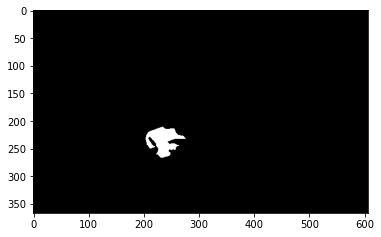

(4, 367, 607, 6, 6)
writing samples 28
/data4/Ukraine_img/M_and_L/20220627T082621_20220627T083534_T37TCN2_size_6_Azovstal_info.pth


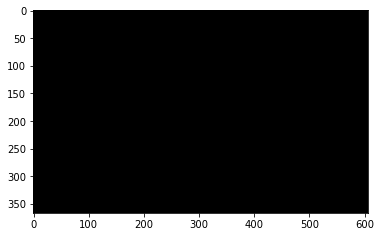

(4, 367, 607, 6, 6)
writing samples 0


0it [00:00, ?it/s]


In [196]:
# city='Azovstal'
cities=dammasks_path.keys()
for city in cities:
    print('-------------------------------------')
    cityimg_pathes10=img_pathes[city]

    # print(city)
    masks10=dammasks_path[city]

    # print(masks)
    k_interval=list(cityimg_pathes10.keys())

    print(k_interval)
    k_interval.remove('A')
    for k_ in k_interval:
        print()
        print()
        print(k_)
        if len(k_)==1:
            print('loading mask:',k_)
            print(masks10[k_])
            mask_now=torch.load(masks10[k_])
            mask_before=None
            mask_after=None
        else:
            if 'A' in k_:
                print('loading mask:',k_[2])
                print(masks10[k_[2]])
                mask_now=None
                mask_before=None
                mask_after=torch.load(masks10[k_[2]])
            elif 'Z' in k_:
                print('loading mask:',k_[0])
                print(masks10[k_[0]])
                mask_now=None
                mask_before=torch.load(masks10[k_[0]])
                mask_after=None
            else:
                print('loading mask:',k_[0],'and',k_[2])
                print(masks10[k_[0]])
                print(masks10[k_[2]])
                mask_now=None
                mask_before=torch.load(masks10[k_[0]])
                mask_after=torch.load(masks10[k_[2]])  
        pre10_path=cityimg_pathes10['A'][0]
        pre_info=torch.load(pre10_path)
        pre_img=[pre_info['img10'],pre_info['img20']]
        post10_pathes=cityimg_pathes10[k_]
        if len(post10_pathes)==0:
            continue
        post10_pathes.sort()
        print('load img:',k_)
        print(post10_pathes)
        for post10_path in post10_pathes:
            print(post10_path)
            post_info=torch.load(post10_path)
            post_img=[post_info['img10'],post_info['img20']]
            plt.imshow(post_img[0][:3,:,:,1,1].transpose((1,2,0)))
            plt.show()
            samples,zz=get_samples(pre_img,post_img,mask_after,mask_now,mask_before)
            print('writing samples',len(samples))
            time.sleep(2)

            samples_root='/ssd/hk/Ukraine_samples/samplesv2/samples_Azovstal/'
            img_id=os.path.basename(post10_path).split('_size')[0].replace('_','-')

            samples_pathes=[samples_root+f'{city}_{img_id}_{str(i[0][0]).zfill(3)+str(i[0][1]).zfill(3)}.pth' for i in samples]
            info=[]

            for i in tqdm(range(len(samples))):
                    # '5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
                    info.append([samples_pathes[i],samples[i][0],samples[i][1]])
                    torch.save(samples[i],samples_pathes[i])
            info_dict={'readme':'4个字段\n 1:pre图像路径\n 2:post图像路径\n 3:图像坐标\n 4:损毁信息\n 损毁信息有5层\n 5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6', 'info':info}
            torch.save(info_dict,f'/ssd/hk/Ukraine_samples/samplesv2/{city}_{img_id}_samples_info.pth')
            # if post10_path=='/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area1_info.pth':
            #     raise

# 创建samples_slip文件

Azovstal
/data4/Ukraine_img/M_and_L/20210910T082601_20210910T083119_T37TCN_size_6_Azovstal_info.pth
t:2561   v:1099


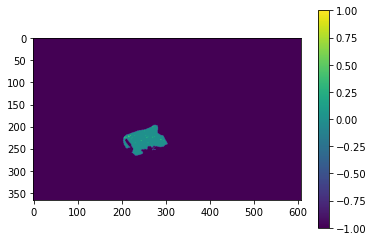

In [197]:
size=6

print(city)
if 'C' in list(dammasks_path[city].keys()):
    dammask_path=dammasks_path[city]['C']
else:
    dammask_path=dammasks_path[city]['B']

dammask=torch.load(dammask_path)['mask'][0]
# plt.imshow(dammask)
# plt.show()
mask_path=img_pathes[city]['A'][0]
print(mask_path)
mask=torch.load(mask_path)['img10'][0]
mask[mask>0]=1
# plt.imshow(mask[:,:,0,0])
# plt.show()
shape=mask.shape




sample_mask=np.zeros((shape[0],shape[1]))
sample_p=[]
sample_n=[]
for x in range(shape[0]):
    for y in range(shape[1]):
        if dammask[x,y]>0:
            sample_mask[x,y]=1
        if (mask[x,y]==0).any() and (mask[x,y]==0).any():
            sample_mask[x,y]=-1
        if sample_mask[x,y]==1:
            sample_p.append([x,y])
        elif sample_mask[x,y]==0:
            sample_n.append([x,y])

p_coord=[str(i[0]).zfill(3)+str(i[1]).zfill(3) for i in sample_p]
n_coord=[str(i[0]).zfill(3)+str(i[1]).zfill(3) for i in sample_n]
random.shuffle(p_coord)
random.shuffle(n_coord)
p_t_coord=p_coord[:int(len(p_coord)*0.7)]
p_v_coord=p_coord[int(len(p_coord)*0.7):]
n_t_coord=n_coord[:int(len(n_coord)*0.7)]
n_v_coord=n_coord[int(len(n_coord)*0.7):]
t=p_t_coord+n_t_coord
v=p_v_coord+n_v_coord
random.shuffle(t)
random.shuffle(v)
print(f't:{len(t)}   v:{len(v)}')
torch.save(t,f'/ssd/hk/Ukraine_samples/coords_splitv2/{city}_train.pth')
torch.save(v,f'/ssd/hk/Ukraine_samples/coords_splitv2/{city}_val.pth')
# plt.figure(figsize=(15,15))
plt.imshow(sample_mask)
plt.colorbar()
plt.show()



In [ ]:
'Azovstal'

In [199]:
def match(string,input_list):
    new_data_list=[i for i in input_list if  re.match(string, i[0]) != None]
    return new_data_list
t=[]
v=[]
city_sample=[]
for i in glob('/ssd/hk/Ukraine_samples/coords_splitv2/Azovstal*train.pth'):
    t+=torch.load(i)
    v+=torch.load(i.replace('train','val'))
print(len(t),len(v))
for i in glob('/ssd/hk/Ukraine_samples/samplesv2/Azovstal*.pth'):
    city_sample+=torch.load(i)['info']
print(len(city_sample))

for i in range(len(city_sample)):
    if len(city_sample[i][2])==2:
        if city_sample[i][2][0] is not None:
            city_sample[i][2]=city_sample[i][2][0]
        else:
            city_sample[i][2]=city_sample[i][2][1]
city_pathes=[[i[0],'n'] if i[2][0]==0 else [i[0],'p'] for i in city_sample]
random.shuffle(city_pathes)
import re
city_coord_sample={}
city_coord_sample['train']={}
city_coord_sample['val']={}
print('match train')
time.sleep(2)
for i in tqdm(t):
    a=match(f'.*{i}.pth',city_pathes)
    a.sort()
    city_coord_sample['train'][i]=a
print('match val')
time.sleep(2)
for i in tqdm(v):
    a=match(f'.*{i}.pth',city_pathes)
    a.sort()
    city_coord_sample['val'][i]=a
torch.save(city_coord_sample,f'/ssd/hk/Ukraine_samples/split_coordv2_Azovstal_v2/samples.pth') 



t=[]
for i in city_coord_sample['train'].keys():
    t+=city_coord_sample['train'][i]
v=[]
for i in city_coord_sample['val'].keys():
    v+=city_coord_sample['val'][i]
random.shuffle(t)
random.shuffle(v)
# torch.save(t,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/train.pth') 
# torch.save(v,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/val.pth') 

2561 1099
14780
match train


100%|██████████| 2561/2561 [00:33<00:00, 77.18it/s]


match val


100%|██████████| 1099/1099 [00:14<00:00, 77.13it/s]


In [200]:
torch.save(t,f'/ssd/hk/Ukraine_samples/'p'/train.pth') 
torch.save(v,f'/ssd/hk/Ukraine_samples/split_coordv2_Azovstal_v2/val.pth') 

In [206]:
print(len(t))
len([i  for i in t if i[1]=='p'])


10343


216

In [207]:
print(len(v))
len([i  for i in v if i[1]=='p'])

4437


99

In [214]:
import gdal
import torch
s=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_Azovstal_v2/samples.pth')
tt=[]
for i in s['train'].keys():
    t_p=[j[0] for j in s['train'][i]]+[None]*(20-len(s['train'][i]))
    t_l=[j[1] for j in s['train'][i]]+[None]*(20-len(s['train'][i]))
    tt.append([t_p,t_l])
vv=[]
for i in s['val'].keys():
    t_p=[j[0] for j in s['val'][i]]+[None]*(20-len(s['val'][i]))
    t_l=[j[1] for j in s['val'][i]]+[None]*(20-len(s['val'][i]))
    vv.append([t_p,t_l])
print(len(tt),len(vv))
torch.save(tt,'/ssd/hk/Ukraine_samples/split_coordv2_Azovstal_v3/train.pth')
torch.save(vv,'/ssd/hk/Ukraine_samples/split_coordv2_Azovstal_v3/val.pth')

In [229]:
tt=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_Azovstal_v3/train.pth')+torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/train.pth')
vv=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_Azovstal_v3/val.pth')+torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/val.pth')
random.shuffle(tt)
random.shuffle(vv)
torch.save(tt,'/ssd/hk/Ukraine_samples/split_coordv2_all_v3/train.pth')
torch.save(vv,'/ssd/hk/Ukraine_samples/split_coordv2_all_v3/val.pth')

In [244]:
k=[]
for i in tt:
    p=[j for j in i[0] if j is not None]
    l=[j for j in i[1] if j is not None]
    for j in range(len(p)):
        k.append([p[j],l[j]])
random.shuffle(k)
torch.save(k,'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/M/train.pth')

In [246]:
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/ML/train.pth')))
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/Azovstal/train.pth')))
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/M/train.pth')))
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/ML/val.pth')))
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/Azovstal/val.pth')))
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/M/val.pth')))

49862
10343
60205
21301
4437
25738


In [242]:
49862+10343

60205

In [262]:
f=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Azovstal/train.pth')
print(len(f))
k=[]
for i in f:
    z=[j for j in i[0] if j is not None]
    if len(z)>0:
        k.append(i)
print(len(k))
f=torch.save(k,'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Azovstal/train.pth')

2561
2561
